# Assignment 1: Ligand-Based Virtual Screening
By Adrián Barreno Sánchez and Álvaro González Berdasco

### Molecular mecanisms of Cutaneous Melanoma

Melanoma is a highly aggressive cancer type with a strong tendency to metastasize . When diagnosed at an early stage, removal of local tumors is mostly curative, however, late diagnosis of invasive or metastatic melanoma often carries a poor prognosis [1].

Melanomas originate from the malignant transformation of melanocytes, neural-crest derived cells specialized in the production of the pigment melanin, which contributes to skin and hair pigmentation and confers ultraviolet light protection [2]. Cutaneous melanoma, originated from the melanocytes at the basal layer of the epidermis, is the most common form of the disease.

The malignant transformation of melanocytes is the result of a complex interaction between both exogenous and genetic factors [1]. Ultraviolet (UV) exposure is the main risk factor of cutaneous melanoma. UV radiation, stimulates cyclic AMP production through a melanocortin-dependant mechanism, leading to increased proliferation and melanogenesis [3]. This proliferative process is regulated by BRAF, a serine-threonine kinase that triggers the MAP kinase pathway [3]. The importance of this pathway in melanocyte growth might explain its extraordinary high mutation frequency. Importantly, up to 70% of human melanomas harbor mutations in BRAF [3].

The most common BRAF mutation, which accounts for more than 90% malinganices involving this gene, is a substitution of glutamic acid for valine at position 600 (V600E) [3].Mutated BRAFV600E shows approximately a 500-fold increased activity and it induces constitutive signaling through the RAS–MEK–ERK pathway (MAP kinase signaling pathway) and Nuclear factor kappa-B (NF-kB) activation [2, 4]. Through complex downstream mechanisms, BRAF activity promotes cell survival, proliferation, angiogenesis, invasion and metastasis [5].

Mutated BRAF has been observed to play an important role in malignant melanocyte transformation and is already present and in up to 80% of the benign skin leasions called naevi [2]. Moreover, mutated BRAF activity stimulates many of the hallmarks of cancer. This suggests that BRAF mutation might be a founder event in the onset of the disease and sustain its prograssion [2].

Besides melanoma, somatic mutations in BRAF occur in approximately 7% of human cancers [2, 3], showing an important tumor-promoting activity in thyroid, colorectal, ovarian and lung cancers, and other malignancies [3, 5].


### Hypothesis for drug design
We propose that BRAF inhibition would be an optimal therapeutical approach for BRAFV600E-mutated melanomas. Through the inhibition os the BRAF serine/threonine-protein kinase we would be able to stop the siganling pathway that leads to cell proliferation and survival at an uptream position. Moreover, since BRAF mutation appears at early stages of the disease, it could be an appropriate potential treatment to avoid melanoma progression.

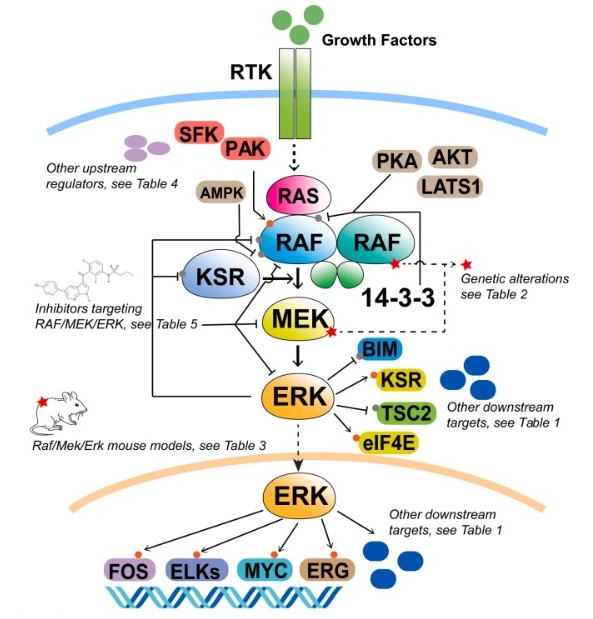

The RAF/MEK/ERK signaling cascade.The arrowhead indicates positive regulation of the target protein, while the blunt head indicates negative regulation of the target protein. Figure from Ullah et al. (2021)[6].

## 1) Identifying our target molecule from CHEMBL database

By doing a quick search, we found the UNIPROT code for our protein of interest: P15056 -> BRAF Ser/Thr kinase  

UNIPROT and CHEMBL have different identifiers. Let's start by finding the ChEMBL identifier for our target protein.

In [66]:
# libraries
import json            # lets us work with the json format
import requests        # allows Python to make web requests
import pandas as pd    # analysis of tabular data
import numpy as np     # numerical library

BASE_URL = "https://www.ebi.ac.uk/chembl/api/data/{:s}"

In [ ]:
target_protein_url = BASE_URL.format("target_component?accession=P15056")
target_components = requests.get(target_protein_url, headers={"Accept":"application/json"}).json()["target_components"]
target_components[0]["targets"]

[{'target_chembl_id': 'CHEMBL5145'},
 {'target_chembl_id': 'CHEMBL3559685'},
 {'target_chembl_id': 'CHEMBL3883317'},
 {'target_chembl_id': 'CHEMBL4106189'},
 {'target_chembl_id': 'CHEMBL4523687'}]

We need to filter the target components obtained aacording to the "target type", so we only use as a target the single protein B-RAF.

In [ ]:
targets_list = ';'.join([i['target_chembl_id'] for i in target_components[0]["targets"]])
print(targets_list)
targets_url = BASE_URL.format("target/set/{:s}".format(targets_list))

targets = requests.get(targets_url, headers={"Accept":"application/json"}).json()["targets"]

# targets is an array of target data (dictionaries) for each particular target within the set.

for i in targets:
    print(i['target_chembl_id'], i['target_type'], i['pref_name'])

CHEMBL5145;CHEMBL3559685;CHEMBL3883317;CHEMBL4106189;CHEMBL4523687
CHEMBL5145 SINGLE PROTEIN Serine/threonine-protein kinase B-raf
CHEMBL3559685 PROTEIN FAMILY RAF serine/threonine protein kinase
CHEMBL3883317 PROTEIN FAMILY B-raf/RAF proto-oncogene serine/threonine-protein kinase
CHEMBL4106189 PROTEIN COMPLEX BRAF/CRAF
CHEMBL4523687 PROTEIN-PROTEIN INTERACTION Protein cereblon/BRAF


We will only consider for the ligand-based virtual screening the single protein target (CHEMBL5145).

## 2) Finding a query molecule from activity data

Once identified, we start searching molecules related to our target. We will search activity data from assays performed with our target protein.


In [ ]:
#Define activity_url
activity_url = BASE_URL.format ("activity?target_chembl_id__exact=CHEMBL5145&standard_type__exact=IC50&offset=0&limit=0&assay_variant_mutation__exact=V600E")
activity_request = requests.get(activity_url, headers={"Accept":"application/json"}).json()['activities']

# Transform data in a table
activity_table = pd.DataFrame.from_dict(activity_request)[['target_chembl_id','molecule_chembl_id', 'standard_type',
                                                          'standard_value', "standard_units", 'assay_description',"target_organism",
                                                          'assay_variant_mutation','canonical_smiles']]
print(len(activity_table), "assays found")

1000 assays found


We filter the activity data to only consider assays evaluating the half maximal inhibitory concentration of the molecule (IC50). Then we sort the molecules based on the IC50 standard value.

In [ ]:
# Select assays with type IC50
activity_table_ic50 = activity_table[activity_table['standard_type']=="IC50"]

# Sort compounts by stadard IC50 value (uM). To achieve a correct sorting, we need to
# explicitly conver stardard value to float type. Remove NaN values.
activity_table_ic50['standard_value'] = activity_table_ic50['standard_value'].astype(float)
activity_table_ic50 = activity_table_ic50.sort_values(by = ['standard_value'], ascending=[True]).reset_index(drop=True)
activity_table_ic50

,target_chembl_id,molecule_chembl_id,standard_type,standard_value,standard_units,assay_description,target_organism,assay_variant_mutation,canonical_smiles
0,CHEMBL5145,CHEMBL525191,IC50,0.13,nM,Inhibition of B-Raf V600E mutant,Homo sapiens,V600E,OCCn1cc(-c2ccc3c(c2)CC/C3=N\O)c(-c2ccncc2)n1
1,CHEMBL5145,CHEMBL1668922,IC50,0.20,nM,Inhibition of B-Raf V600E mutant,Homo sapiens,V600E,O/N=C1\CCc2cc(Nc3c(-c4ncccn4)oc4cnccc34)ccc21
2,CHEMBL5145,CHEMBL1667922,IC50,0.30,nM,Inhibition of B-Raf V600E mutant,Homo sapiens,V600E,Cc1cc(Nc2c(-c3ncccn3)oc3cnccc23)c2cn[nH]c2c1Cl
3,CHEMBL5145,CHEMBL385956,IC50,0.46,nM,Inhibition of recombinant Braf V600E mutant,Homo sapiens,V600E,Cc1ccc(C(=O)Nc2cccc(C(F)(F)F)c2)cc1Nc1ncccc1-c...
4,CHEMBL5145,CHEMBL1667899,IC50,0.50,nM,Inhibition of B-Raf V600E mutant,Homo sapiens,V600E,O/N=C1\NCc2cc(Nc3c(-c4ncccn4)oc4cnccc34)ccc21
...,...,...,...,...,...,...,...,...,...
995,CHEMBL5145,CHEMBL1782176,IC50,NaN,None,Inhibition of B-Raf V600E mutant-mediated ERK ...,Homo sapiens,V600E,O=C(c1cccc(C(F)(F)F)c1F)N1N=C(c2cccnc2)CC1c1cc...
996,CHEMBL5145,CHEMBL1782175,IC50,NaN,None,Inhibition of B-Raf V600E mutant-mediated ERK ...,Homo sapiens,V600E,O=C(c1cccc(Oc2ccccc2)c1)N1N=C(c2cccnc2)CC1c1cc...
997,CHEMBL5145,CHEMBL1782174,IC50,NaN,None,Inhibition of B-Raf V600E mutant-mediated ERK ...,Homo sapiens,V600E,O=C(c1ccccc1Oc1ccccc1)N1N=C(c2cccnc2)CC1c1ccccc1O
998,CHEMBL5145,CHEMBL1782173,IC50,NaN,None,Inhibition of B-Raf V600E mutant-mediated ERK ...,Homo sapiens,V600E,O=C(c1ccccc1-c1ccc(F)cc1)N1N=C(c2cccnc2)CC1c1c...


We identify CHEMBL500659 as the molecule with the highest inhibitory activity reported, with a IC50 value of 0.02 nM.

This molecule appears in just one article [7]. In this study, the authors compare several pyrazole-based class of ATP competitive B-Raf inhibitors. The molecule we have just obtained was one of the three best performing molecules in the IC50 assays carried out in this study (out of 37), so we are confident with our selection.

## 3) Find approved drugs for our target

In [67]:
mechanism_url = "https://www.ebi.ac.uk/chembl/api/data/mechanism?target_chembl_id__exact=CHEMBL5145&max_phase=4"
mechanism_request = requests.get(mechanism_url, headers={"Accept":"application/json"}).json()
mechanism_table = pd.DataFrame.from_dict(mechanism_request['mechanisms'])[['molecule_chembl_id','target_chembl_id', 'max_phase', 'mechanism_comment', 'selectivity_comment']]
mechanism_table

,molecule_chembl_id,target_chembl_id,max_phase,mechanism_comment,selectivity_comment
0,CHEMBL2105729,CHEMBL5145,4,None,None
1,CHEMBL1946170,CHEMBL5145,4,None,Also active against BRAFV600E
2,CHEMBL1200485,CHEMBL5145,4,None,None
3,CHEMBL1229517,CHEMBL5145,4,Indicated for mutated form - V600E,None
4,CHEMBL3301612,CHEMBL5145,4,Selective for mutation containing BRAF (V600E ...,None


Among these molecules, we will proceed with Vemurafenib (CHEMBL1229517), the first target-specific BRAF-V600E inhibitor aproved (First in Class) and the one with the largest number of Lipinski rules fulfilled.

## 4) Similarity search for query molecule CHEMBL1229517

### UNIPROT database

Once we have selected our query molecule, we proceeded to make a similarity search in order to build a database with an adecuate number of molecules for further analisys while keeping the similarity threshold as high as possible.

In [70]:
BASE_URL_pub = "https://pubchem.ncbi.nlm.nih.gov/rest/pug"
DATOS = { 'smiles' : "CCCS(=O)(=O)Nc1ccc(F)c(C(=O)c2c[nH]c3ncc(-c4ccc(Cl)cc4)cc23)c1F" }
url_2d = BASE_URL_pub +"/compound/fastsimilarity_2d/smiles/cids/txt?Threshold=85"     #2D similarity search
response_2d = requests.post(url_2d,data=DATOS)

cids_2d = response_2d.text.split()

print("# Number of compounds:", len(cids_2d))

# Number of compounds: 4342


In [69]:
DATOS = { 'smiles' : "CCCS(=O)(=O)Nc1ccc(F)c(C(=O)c2c[nH]c3ncc(-c4ccc(Cl)cc4)cc23)c1F" }
url_3d = BASE_URL_pub +"/compound/fastsimilarity_3d/smiles/cids/txt?Threshold=95"      #3D similarity search
response_3d = requests.post(url_3d,data=DATOS)
cids_3d = response_3d.text.split()

print("# Number of CIDs:", len(cids_3d))

# Number of CIDs: 71


We decided to merge the results from the 2D- and the 3D-similarity screening to obtain a complete list of drug candidates. We will obtain the canonical Smiles of our resulting molecules for further analysis with RDKit tool.

In [ ]:
from time import time

cids_merge = cids_2d + cids_3d
print("# Total compounds:", len(cids_merge))

data=[]
start=time()
for cid in cids_merge:
  url = BASE_URL_pub +f"/compound/cid/{cid}/property/canonicalSmiles/JSON"
  response = requests.get(url).json()
  print(response["PropertyTable"]["Properties"])
  data.append(response["PropertyTable"]["Properties"][0])
stop=time()
print("Total request time:", str(stop-start))

df = pd.DataFrame.from_dict(data)
df
# database = df.groupby("CanonicalSMILES", as_index=False).min().reset_index(drop = True)
# print(str(database.shape[0]), "structurally different molecules")
# database.to_csv("./PubchemSimilarity_V600E_mutation.csv", index = False)
# database

# Total compounds: 6759
[{'CID': 128748, 'CanonicalSMILES': 'C1=CC=C(C=C1)C2=CC(=NN2CCO)C3=CC=CC=C3'}]
[{'CID': 57519545, 'CanonicalSMILES': 'C1CC(=NO)C2=C1C=C(C=C2)C3=CN(N=C3C4=CC=NC=C4)CCO'}]
[{'CID': 25093303, 'CanonicalSMILES': 'C1CC(=NO)C2=C1C=C(C=C2)C3=CN(N=C3C4=CC=NC=C4)CCO'}]
[{'CID': 11717001, 'CanonicalSMILES': 'C1CC(=NO)C2=C1C=C(C=C2)C3=CN(N=C3C4=CC=NC=C4)CCO'}]
[{'CID': 11703284, 'CanonicalSMILES': 'CC1=NC(=CC=C1)C2=C(C=NN2)C3=CC(=C(C=C3)F)C4=CN(N=C4)CCO'}]
[{'CID': 314123, 'CanonicalSMILES': 'C1C2=CC=CC=C2C3=C1C(=NN3)C4=CC=NC=C4'}]
[{'CID': 66015333, 'CanonicalSMILES': 'C1=CC=C(C=C1)C2=NN(C=C2)C3=CC=NC=C3'}]
[{'CID': 11653652, 'CanonicalSMILES': 'C1CNCCC1N2C=C(C(=N2)C3=CC=NC=C3)C4=CC5=C(C=C4)C(=NO)CC5'}]
[{'CID': 135508240, 'CanonicalSMILES': 'CN1C(=C(C=N1)C2=CC3=C(C=C2)C(=NO)CC3)C4=CC=NC=C4'}]
[{'CID': 135505774, 'CanonicalSMILES': 'CN1C=C(C(=N1)C2=CC=NC=C2)C3=CC4=C(C=C3)C(=NCC4)NO'}]
[{'CID': 135466457, 'CanonicalSMILES': 'C1CC(=NO)C2=C1C=C(C=C2)C3=C(NN=C3)C4=CC=NC=C4'}]

KeyError: ignored

This iteration to extract the SMILES of our compounds has been the most time-consuming part of the similarity screening process.

Importantly, this similarity screening has returned multiple molecules with the same SMILES sequence, that is, conformational isomers. These conformers are redundant in our analysis, therefore, we will group molecules by their SMILES and preserve only que isomeric form with the lowest IC50.

In [ ]:
database = df.groupby("CanonicalSMILES", as_index=False).min().reset_index(drop = True)
print(str(database.shape[0]), "structurally different molecules")
database

Once done, we will save the compound dataframe into a CSV file in our working directory and continue processing the data.

In [ ]:
database.to_csv("./PubchemSimilarity_2D_85_3D_95.csv", index = False)

## 5) Analysing similar molecules to our query using RDKit

Next, we aim to analyze the molecules in our database and compare them according to their similarity to our query molecule. To do this, we will obtain the Morgan and Maccs fingerprints of the different molecules and calculate their Tanimoto and Dice similarity coefficients.

In [2]:
# We first install RDKit and required libraries.
!pip install rdkit-pypi

import rdkit.Chem.AllChem as AllChem # rdkit. chemoinformatics
import rdkit.Chem as Chem
from rdkit.Chem import Draw
from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem
from rdkit.Chem import MACCSkeys
from rdkit.Chem import PandasTools
from rdkit import DataStructs
from rdkit.Chem import rdFingerprintGenerator
import math
import matplotlib.pyplot as plt
import pandas as pd # analysis of tabular data

We load our query molecule from its canonical smiles.

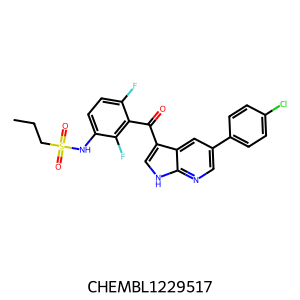

In [9]:
query = Chem.MolFromSmiles('CCCS(=O)(=O)Nc1ccc(F)c(C(=O)c2c[nH]c3ncc(-c4ccc(Cl)cc4)cc23)c1F')        #Coordinates for 2D depiction are generated automatically
Draw.MolToImage(query, legend = "CHEMBL1229517")

Then, we load the database CSV file we obtained from PubChem similarity screening. We add a column to the Data Frame with the Molecule object for each compound.

In [50]:
db = pd.read_csv("./PubchemSimilarity_Vemurafenib_V600E_85%.csv")

PandasTools.AddMoleculeColumnToFrame(db, smilesCol='CanonicalSMILES')
print("# Number of compouds:",len(db))
db.head(1000)

# Number of compouds: 4222


[21:44:55] Explicit valence for atom # 1 Br, 3, is greater than permitted
[21:44:57] Explicit valence for atom # 27 Br, 3, is greater than permitted
[21:44:57] WARNING: not removing hydrogen atom without neighbors
[21:44:57] WARNING: not removing hydrogen atom without neighbors
[21:44:57] WARNING: not removing hydrogen atom without neighbors
[21:44:57] WARNING: not removing hydrogen atom without neighbors
[21:44:57] WARNING: not removing hydrogen atom without neighbors
[21:44:57] WARNING: not removing hydrogen atom without neighbors
[21:44:57] WARNING: not removing hydrogen atom without neighbors
[21:44:57] WARNING: not removing hydrogen atom without neighbors
[21:44:57] WARNING: not removing hydrogen atom without neighbors
[21:44:57] WARNING: not removing hydrogen atom without neighbors
[21:44:57] WARNING: not removing hydrogen atom without neighbors
[21:44:57] WARNING: not removing hydrogen atom without neighbors
[21:44:57] WARNING: not removing hydrogen atom without neighbors
[21:44

,CanonicalSMILES,CID,ROMol
0,B(C1=C(C=C(C=C1)Cl)Cl)(O)O.CCCS(=O)(=O)NC1=C(C...,160430824,<rdkit.Chem.rdchem.Mol object at 0x00000192352...
1,B(C1=C(C=C(C=C1)F)Cl)(O)O.CCCS(=O)(=O)NC1=C(C(...,160815540,<rdkit.Chem.rdchem.Mol object at 0x00000192352...
2,B(C1=CC(=CC=C1)N)(O)OCCCS(=O)(=O)NC2=C(C(=C(C=...,163492014,<rdkit.Chem.rdchem.Mol object at 0x00000192352...
3,B(C1=CC=C(C=C1)Cl)(O)O.CCCS(=O)(=O)NC1=C(C(=C(...,160390413,<rdkit.Chem.rdchem.Mol object at 0x00000192352...
4,B(C1=CC=C(C=C1)Cl)(O)O.CS(=O)(=O)NC1=CC=CC(=C1...,162001027,<rdkit.Chem.rdchem.Mol object at 0x00000192352...
...,...,...,...
995,C1CN(CC1F)S(=O)NC2=C(C(=C(C=C2)F)C(=O)C3=CNC4=...,162741842,<rdkit.Chem.rdchem.Mol object at 0x00000192368...
996,C1CN(CC1F)SNC2=C(C(=C(C=C2)F)C(=O)C3=CNC4=C3C=...,142390479,<rdkit.Chem.rdchem.Mol object at 0x00000192368...
997,C1CN(CCN1)C2=CC=C(C=C2)C3=CC4=C(NC=C4C(=O)C5=C...,162786141,<rdkit.Chem.rdchem.Mol object at 0x00000192368...
998,C1CN(C[CH+]1)S(=O)(=O)NC2=C(C(=C(C=C2)F)C(=O)C...,123940017,<rdkit.Chem.rdchem.Mol object at 0x00000192368...


Some molecules have been incorrectly converted to Mol Object due to errors in SMILES reading, we need to drop them.

In [51]:
print(f"Errors detected in SMILES conversion:\n{db.isna().sum()}")
db.dropna(inplace=True)

Errors detected in SMILES conversion:
CanonicalSMILES    0
CID                0
ROMol              2
dtype: int64


<class 'list'> <class 'list'>


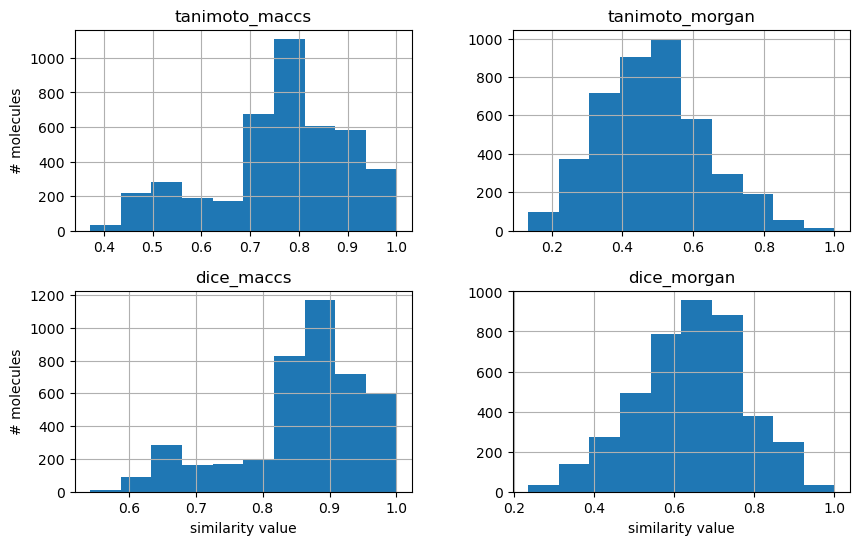

In [59]:
# Fingerprints of our query
MACCQuery = MACCSkeys.GenMACCSKeys(query)
MorganQuery = rdFingerprintGenerator.GetFPs([query])[0]

# Adding to the dataframe every molecule's fingerprint
MACCSDatabase = db.ROMol.apply(MACCSkeys.GenMACCSKeys).to_list() ##MACCS Keys generation
MorganDatabase = rdFingerprintGenerator.GetFPs(db["ROMol"].tolist()) ##Morgan Fingerprints generation

print(type(MACCSDatabase), type(MorganDatabase))
# Calculating tanimoto and dice's coefficients for each type of fingerprint
db["tanimoto_maccs"] = DataStructs.BulkTanimotoSimilarity(MACCQuery, MACCSDatabase)
db["dice_maccs"] = DataStructs.BulkDiceSimilarity(MACCQuery, MACCSDatabase)
db["tanimoto_morgan"] = DataStructs.BulkTanimotoSimilarity(MorganQuery, MorganDatabase)
db["dice_morgan"] = DataStructs.BulkDiceSimilarity(MorganQuery, MorganDatabase)

# # Plotting the distribution of similarity coefficients
fig, axes = plt.subplots(figsize=(10, 6), nrows=2, ncols=2)
db.hist(["tanimoto_maccs"], ax=axes[0, 0])
db.hist(["tanimoto_morgan"], ax=axes[0, 1])
db.hist(["dice_maccs"], ax=axes[1, 0])
db.hist(["dice_morgan"], ax=axes[1, 1])
axes[1,0].set_xlabel("similarity value")
axes[1,1].set_xlabel("similarity value")
axes[0,0].set_ylabel("# molecules")
axes[1,0].set_ylabel("# molecules")
plt.show()


As we can see in the graphs, the highest similarity values are obtained when the Dice coefficients are calculated using MACCS fingerprints. Therefore, we will filter our database using the dice coefficients of MACCS fingerprints and setting a cut-off value of 0.95.

In [63]:
# Setting cut-off value and filtering
dbfilter = db.loc[db['dice_maccs'].astype('float') > 0.95].reset_index(drop = True)
print("Number of filtered molecules:", len(dbfilter. index))

dbfilter[["tanimoto_maccs", "tanimoto_morgan", "dice_maccs", "dice_morgan"]].head()


Number of filtered molecules: 682


,tanimoto_maccs,tanimoto_morgan,dice_maccs,dice_morgan
0,0.918919,0.550000,0.957746,0.709677
1,0.957746,0.605634,0.978417,0.754386
2,0.971831,0.983333,0.985714,0.991597
3,0.928571,0.487500,0.962963,0.655462
4,0.914286,0.611111,0.955224,0.758621


In [71]:
# Creating a new file with the final database
dbfilter.to_csv('final_similarity_Vemurafenib_85%.csv', sep = ',', index = False)
dbfilter

,CanonicalSMILES,CID,ROMol,tanimoto_maccs,dice_maccs,tanimoto_morgan,dice_morgan
0,C.C.C.C.CCCS(=O)(=O)NC1=CC=CC(=C1F)C(=O)C2=CNC...,159417127,<rdkit.Chem.rdchem.Mol object at 0x00000192368...,0.918919,0.957746,0.550000,0.709677
1,C.CCCS(=O)(=O)NC1=C(C(=C(C=C1)Cl)C(=O)C2=CNC3=...,157249382,<rdkit.Chem.rdchem.Mol object at 0x00000192368...,0.957746,0.978417,0.605634,0.754386
2,C.CCCS(=O)(=O)NC1=C(C(=C(C=C1)F)C(=O)C2=CNC3=C...,160643258,<rdkit.Chem.rdchem.Mol object at 0x00000192368...,0.971831,0.985714,0.983333,0.991597
3,C1=CC(=C(C(=C1C(=O)C2=CNC3=C2C=C(C=N3)C4=CN=C(...,146302457,<rdkit.Chem.rdchem.Mol object at 0x00000192368...,0.928571,0.962963,0.487500,0.655462
4,C1=CC(=C(C(=C1NS(=O)(=O)CCC(F)(F)F)F)C(=O)C2=C...,87088899,<rdkit.Chem.rdchem.Mol object at 0x00000192368...,0.914286,0.955224,0.611111,0.758621
...,...,...,...,...,...,...,...
677,CCS(=O)(=O)NC1=C(C(=C(C=C1)F)C(=O)CC2=CN=C3C(=...,58251969,<rdkit.Chem.rdchem.Mol object at 0x00000192367...,0.913043,0.954545,0.397590,0.568966
678,CCS(=O)(=O)NC1=C(C=CC(=C1F)C(=O)C2=CNC3=C2C=C(...,164938927,<rdkit.Chem.rdchem.Mol object at 0x00000192367...,0.927536,0.962406,0.540541,0.701754
679,CCS(=O)(=O)NC1=C(C=CC(=C1F)C(=O)C2=CNC3=C2C=C(...,164938923,<rdkit.Chem.rdchem.Mol object at 0x00000192367...,0.915493,0.955882,0.493671,0.661017
680,[B]C1=CC2=C(NC=C2C(=O)C3=C(C=CC(=C3F)NS(=O)(=O...,88917998,<rdkit.Chem.rdchem.Mol object at 0x00000192367...,0.943662,0.971014,0.753846,0.859649


Finally, we obtained a csv file with our filtered database. We have ended the ligand_base virtual screening process with 682 candidates to drugs. 

# REFERENCES

1. Schadendorf, D., van Akkooi, et al. (2018). Melanoma. The Lancet, 392(10151), 971–984. doi:10.1016/s0140-6736(18)31559-9.

2. Dhomen N. and Marais, R. (2007). New insight into BRAF mutations in cancer. Current Opinion in Genetics & Development, 17:31–39.

3. Davies H, Bignell GR, et al. (2002). Mutations of the BRAF gene in human cancer. Nature, 417:949-954.

4. Satyamoorthy, K., Li, G., et al. (2003). Constitutive mitogen-activated protein kinase activation in melanoma is mediated by both BRAF mutations and autocrine growth factor stimulation. Cancer Res, 63:756-759.

5. Chavda J., Bhatt H. (2020). Systemic review on B-RafV600E mutation as potential therapeutic target for the treatment of cancer. European Journal of Medicinal Chemistry, 206, 112675.

6. Ullah, R., Yin, Q., et al. (2021). RAF-MEK-ERK pathway in cancer evolution and treatment. Seminars in Cancer Biology.

7. Hansen, J. D., Grina, J., et al. (2008). Potent and selective pyrazole-based inhibitors of B-Raf kinase. Bioorganic & Medicinal Chemistry Letters, 18(16), 4692–4695. doi:10.1016/j.bmcl.2008.07.002. 
